In [235]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix
import seaborn as sns
from patsy import dmatrices, dmatrix
from sklearn import metrics

# 1. Data ingest #

In [170]:
df = pd.read_csv("Credit.csv")
df = df.drop(columns=['Unnamed: 0'])
print(df.head())
df_cat = df.astype({'Gender': 'category', 'Student': 'category', 'Married': 'category', 'Ethnicity': 'category'})
df_cat.dtypes

    Income  Limit  Rating  Cards  Age  Education  Gender Student Married   
0   14.891   3606     283      2   34         11    Male      No     Yes  \
1  106.025   6645     483      3   82         15  Female     Yes     Yes   
2  104.593   7075     514      4   71         11    Male      No      No   
3  148.924   9504     681      3   36         11  Female      No      No   
4   55.882   4897     357      2   68         16    Male      No     Yes   

   Ethnicity  Balance  
0  Caucasian      333  
1      Asian      903  
2      Asian      580  
3      Asian      964  
4  Caucasian      331  


Income        float64
Limit           int64
Rating          int64
Cards           int64
Age             int64
Education       int64
Gender       category
Student      category
Married      category
Ethnicity    category
Balance         int64
dtype: object

In [171]:
# Add indicator variable if income > 50
df['Rich'] = 0
df.loc[df['Income'] > 50, 'Rich'] = 1
df.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance,Rich
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333,0
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903,1
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580,1
3,148.924,9504,681,3,36,11,Female,No,No,Asian,964,1
4,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331,1


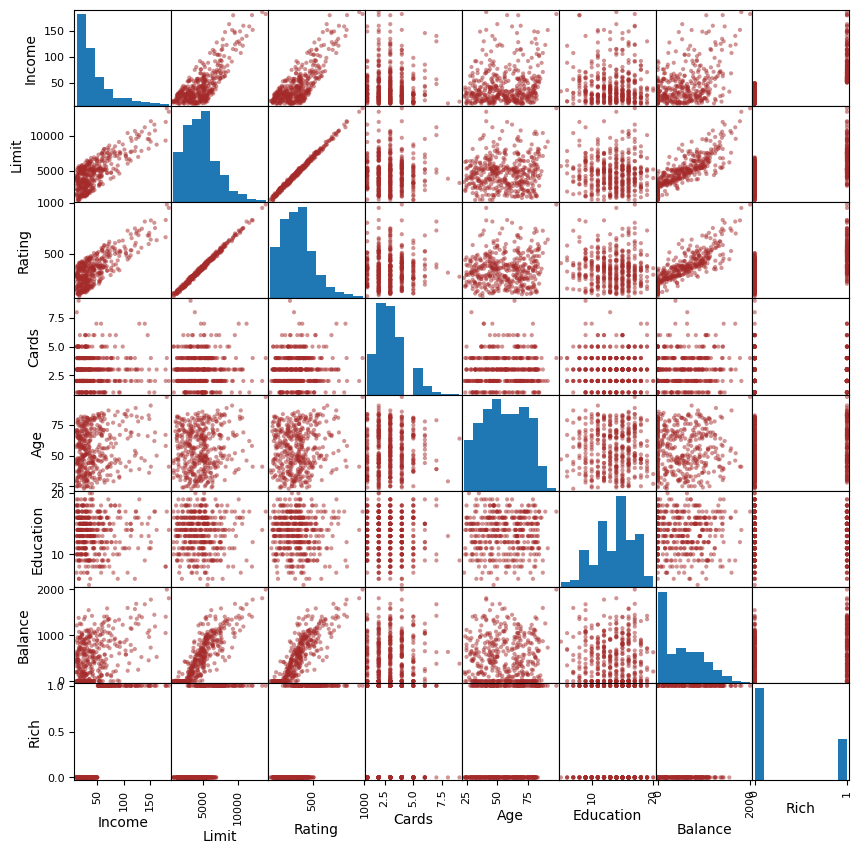

In [172]:
# scatter_plot 
_ = pd.plotting.scatter_matrix(df, color="brown",figsize=(10,10),)

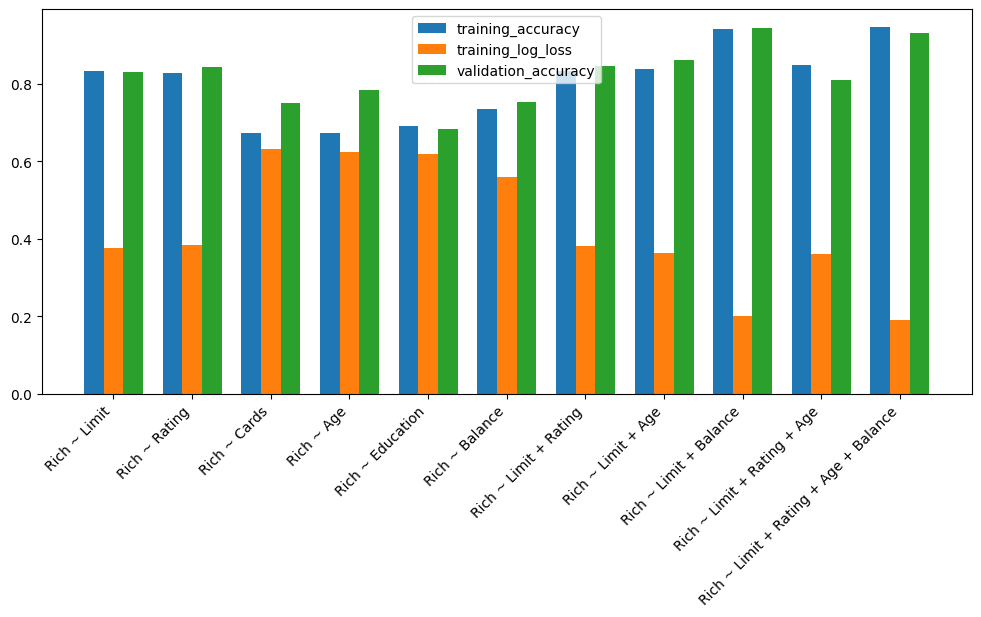

In [267]:
def cardsDataSplit(df):
    cases = df.sort_values(by=['Cards'])
    cases = cases.drop_duplicates(subset=['Cards'], keep='first')
    idx = list(cases.index)
    df = df.drop(index=idx)

    mask = np.random.rand(len(df)) < 0.8
    train = df[mask]
    valid = df[~mask]
    train = pd.concat([cases, train])
    # valid = pd.concat([cases, valid])

    return (train, valid)


def myLogiReg(model_formula, df, multiclass = False, labels=[0,1]):
    """
    Function returns the summary for fitted logiostic model.
    
    Parameter "model_formula" should be a patsy formula describing the model.
    Parameter "df" is a dataframe.
    """
    
    # Split the data into training (80%) and validation set (20%)
    mask = np.random.rand(len(df)) < 0.8
    train = df[mask]
    valid = df[~mask]

    # if multiclass:
    #     train, valid = cardsDataSplit(df.copy(deep=False))

    # Prepare the data (dmatrices is from patsy library)
    y_train, X_train = dmatrices(model_formula, data=train, return_type='dataframe')
    y_train = np.array(y_train).reshape(len(y_train,))
    y_valid, X_valid = dmatrices(model_formula, data=valid, return_type='dataframe')

    # Train the model
    model = LogisticRegression(fit_intercept = False, C = 1e9, max_iter=100000, solver='newton-cholesky')
    y_train = np.array(y_train).reshape(len(y_train,))
    result = model.fit(X_train, y_train)

    # # Train the model
    # if not multiclass:
    #     logit = sm.Logit(y_train, X_train) 
    # else:
    #     logit = sm.MNLogit(y_train, X_train)
    
    # result = logit.fit(disp=0)
    
    training_accuracy = accuracy_score(y_train, model.predict(X_train))
    training_log_loss = log_loss(y_train, model.predict_proba(X_train))
    validation_accuracy = accuracy_score(y_valid, model.predict(X_valid))

    # Retrun fitted model summary
    return (result, training_accuracy, training_log_loss, validation_accuracy)

models = [
    'Rich ~ Limit',
    'Rich ~ Rating',
    'Rich ~ Cards',
    'Rich ~ Age',
    'Rich ~ Education',
    'Rich ~ Balance',
    'Rich ~ Limit + Rating',
    'Rich ~ Limit + Age',
    'Rich ~ Limit + Balance',
    'Rich ~ Limit + Rating + Age',
    'Rich ~ Limit + Rating + Age + Balance',
]

results = [myLogiReg(model, df) for model in models]
training_accuracy = np.array([result[1] for result in results])
training_log_loss = np.array([result[2] for result in results])
validation_accuracy = np.array([result[3] for result in results])

x = np.arange(len(models))
plt.figure(figsize=(12,5))
plt.bar(x, training_accuracy, width=width, label='training_accuracy')
plt.bar(x + 0.25, training_log_loss, width=width, label='training_log_loss')
plt.bar(x + 0.5, validation_accuracy, width=width, label='validation_accuracy')
plt.xticks(ticks=x+0.25, rotation=45, ha='right', labels=models)
plt.legend()
plt.show()

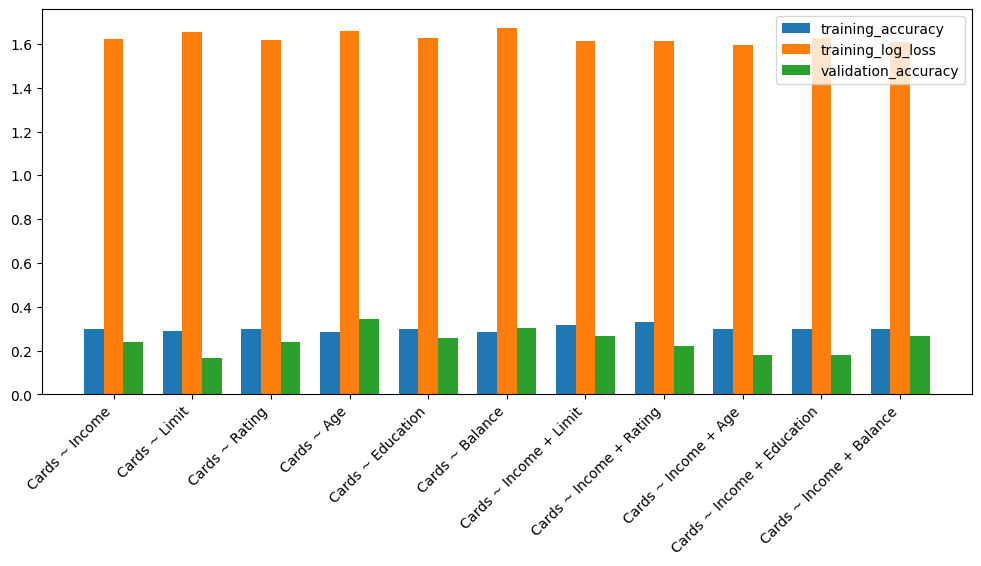

In [268]:
models = [
    'Cards ~ Income',
    'Cards ~ Limit',
    'Cards ~ Rating',
    'Cards ~ Age',
    'Cards ~ Education',
    'Cards ~ Balance',
    'Cards ~ Income + Limit',
    'Cards ~ Income + Rating',
    'Cards ~ Income + Age',
    'Cards ~ Income + Education',
    'Cards ~ Income + Balance',
]

results = [myLogiReg(model, df, multiclass=True, labels=[1,2,3,4,5,6,7,8,9]) for model in models]
training_accuracy = np.array([result[1] for result in results])
training_log_loss = np.array([result[2] for result in results])
validation_accuracy = np.array([result[3] for result in results])

x = np.arange(len(models))
plt.figure(figsize=(12,5))
plt.bar(x, training_accuracy, width=width, label='training_accuracy')
plt.bar(x + 0.25, training_log_loss, width=width, label='training_log_loss')
plt.bar(x + 0.5, validation_accuracy, width=width, label='validation_accuracy')
plt.xticks(ticks=x+0.25, rotation=45, ha='right', labels=models)
plt.legend()
plt.show()